In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import matplotlib.pyplot as plt

In [2]:
# Step 1: Data Collection
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']  # Example tickers
start_date = '2010-01-01'
end_date = '2021-12-31'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  5 of 5 completed


In [27]:
# Step 2: Calculate Pairwise Cointegration using Engle-Granger test

# Implementation of Linear Regression

def linear_regression(y, X):

    y = np.array(y)
    X = np.array(X)
    # Step 1: Calculate means of y and X
    mean_y = np.mean(y)
    mean_X = np.mean(X)
    
    # Step 2: Calculate standard deviations of y and X
    std_y = np.std(y)
    std_X = np.std(X)
    
    # Step 3: Calculate coefficient of correlation
    correlation_coeff = np.corrcoef(X, y)[0, 1]
    
    # Step 4: Calculate coefficient of regression using the formula
    coeff_regression = correlation_coeff * (std_y / std_X)
    
    # Step 5: Calculate intercept using the formula: intercept = mean_y - coeff_regression * mean_X
    intercept = mean_y - coeff_regression * mean_X
    
    # Step 6: Calculate predicted y values
    y_predicted = intercept + coeff_regression * X
    
    # Step 7: Calculate residuals
    residuals = y - y_predicted
    
    return residuals, coeff_regression, intercept


# Implementing ADF test:
def adf_test(residuals):  # Adjust significance level
    result = adfuller(residuals)
    adf_statistic = result[0]
    p_value = result[1]
    return adf_statistic, p_value


# Implementing Engle-Granger Cointegration


def engle_granger_coint(y1, y2):
    # Step 1: Perform linear regression
    residuals, _, _ = linear_regression(y1, y2)

    # Step 2: Perform ADF test on residuals
    adf_statistic, p_value = adf_test(residuals)

    print(p_value)

    # Step 3: Check for cointegration
    if p_value < 0.10:  # Assuming 10% significance level
        return True, adf_statistic, p_value 
    else:
        return False, adf_statistic, p_value
    




In [31]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Test for cointegration
coint_result = coint(data['AAPL'], data['MSFT'])
print(f'p-value: {coint_result[1]}')

p-value: 0.11073855205485456


In [28]:
# Step 3: Calculate Pairwise Cointegration using Engle-Granger test

def find_cointegrated_pairs(data):
    n = len(data.columns)
    pairs = []
    keys = data.columns
    for i in range(n):
        for j in range(i + 1, n):
            stock1 = data[keys[i]].dropna().values  # Drop any rows with NaN values
            stock2 = data[keys[j]].dropna().values  # Drop any rows with NaN values
            if len(stock1) == len(stock2):  # Check if both stocks have the same length after dropping NaN values
                is_cointegrated, _, _ = engle_granger_coint(stock1, stock2)
                if is_cointegrated:
                    pairs.append((keys[i], keys[j]))
    return pairs

In [29]:
# Find cointegrated pairs
pairs = find_cointegrated_pairs(data)
print("Cointegrated pairs:", pairs)


# Example of trading with the first pair found
if pairs:
    stock1, stock2 = pairs[0]
else:
    raise Exception("No cointegrated pairs found")

Res: [-1.23353403 -1.25006105 -1.26746685 ... 54.11184494 55.22453188
 54.45124078]
0.9716726256291366
Res: [-1.1527822  -1.06077383 -0.70304543 ... 15.86736561 15.99358922
 15.3619298 ]
0.09058509281126698
Res: [-5.9912935  -5.98384859 -6.01591195 ... 11.01820489 10.76876896
 10.87586538]
0.035145108385238336
Res: [ -2.21769698  -2.06869279  -1.56659561 ... -45.94805983 -47.35732096
 -47.19324569]
0.7487986504489429
Res: [ -8.70534994  -8.67091181  -8.69669064 ... -52.8181622  -54.73713658
 -53.56922774]
0.9810786775984447
Res: [-5.25874669 -5.33085233 -5.66676789 ...  0.90675373  0.59938884
  1.17945312]
0.17347610966263394
Cointegrated pairs: [('AAPL', 'GOOGL'), ('AAPL', 'MSFT')]


In [ ]:
# Step 5: Implement z-score calculation and trading strategy
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Calculate the spread and z-score
spread = data[stock1] - data[stock2]
zscore_spread = zscore(spread)

In [ ]:
# Step 6: Implement the trading strategy
# Define trading signals based on z-score
entry_zscore = 2.0
exit_zscore = 0.5

positions = pd.DataFrame(index=data.index)
positions[stock1] = 0
positions[stock2] = 0

for i in range(len(data)):
    if zscore_spread[i] > entry_zscore:
        positions[stock1].iloc[i] = -1  # Short stock1
        positions[stock2].iloc[i] = 1   # Long stock2
    elif zscore_spread[i] < -entry_zscore:
        positions[stock1].iloc[i] = 1   # Long stock1
        positions[stock2].iloc[i] = -1  # Short stock2
    elif abs(zscore_spread[i]) < exit_zscore:
        positions[stock1].iloc[i] = 0
        positions[stock2].iloc[i] = 0
    else:
        if i > 0:
            positions[stock1].iloc[i] = positions[stock1].iloc[i - 1]
            positions[stock2].iloc[i] = positions[stock2].iloc[i - 1]

In [ ]:
# Calculate returns from positions
daily_returns = data.pct_change()

strategy_returns = (positions.shift(1) * daily_returns).sum(axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + strategy_returns).cumprod()

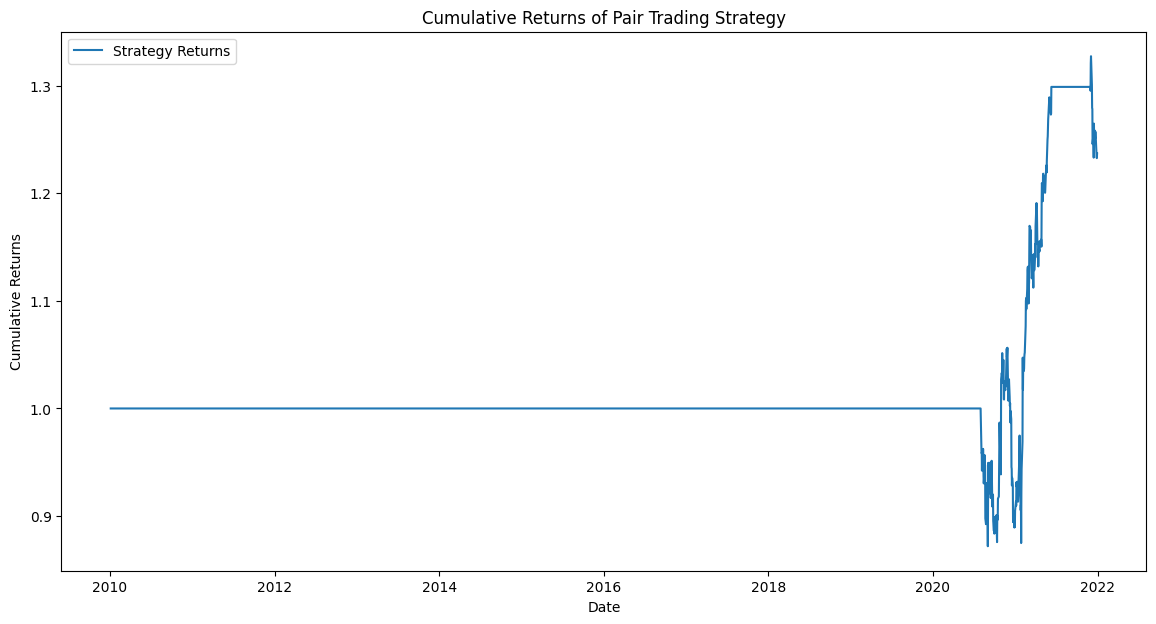

In [ ]:
# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Pair Trading Strategy')
plt.legend()
plt.show()

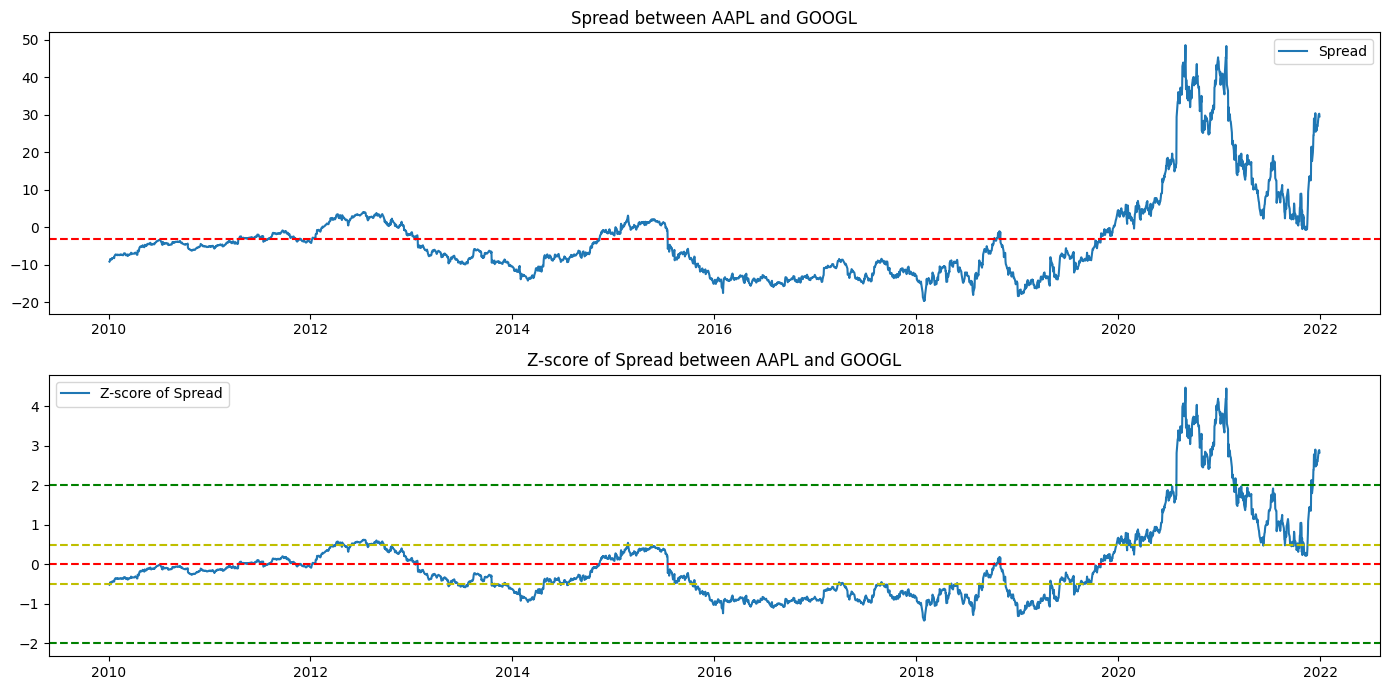

In [ ]:
# Plot the spread and z-score
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(spread, label='Spread')
plt.axhline(spread.mean(), color='r', linestyle='--')
plt.title(f'Spread between {stock1} and {stock2}')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(zscore_spread, label='Z-score of Spread')
plt.axhline(0, color='r', linestyle='--')
plt.axhline(entry_zscore, color='g', linestyle='--')
plt.axhline(-entry_zscore, color='g', linestyle='--')
plt.axhline(exit_zscore, color='y', linestyle='--')
plt.axhline(-exit_zscore, color='y', linestyle='--')
plt.title(f'Z-score of Spread between {stock1} and {stock2}')
plt.legend()

plt.tight_layout()
plt.show()

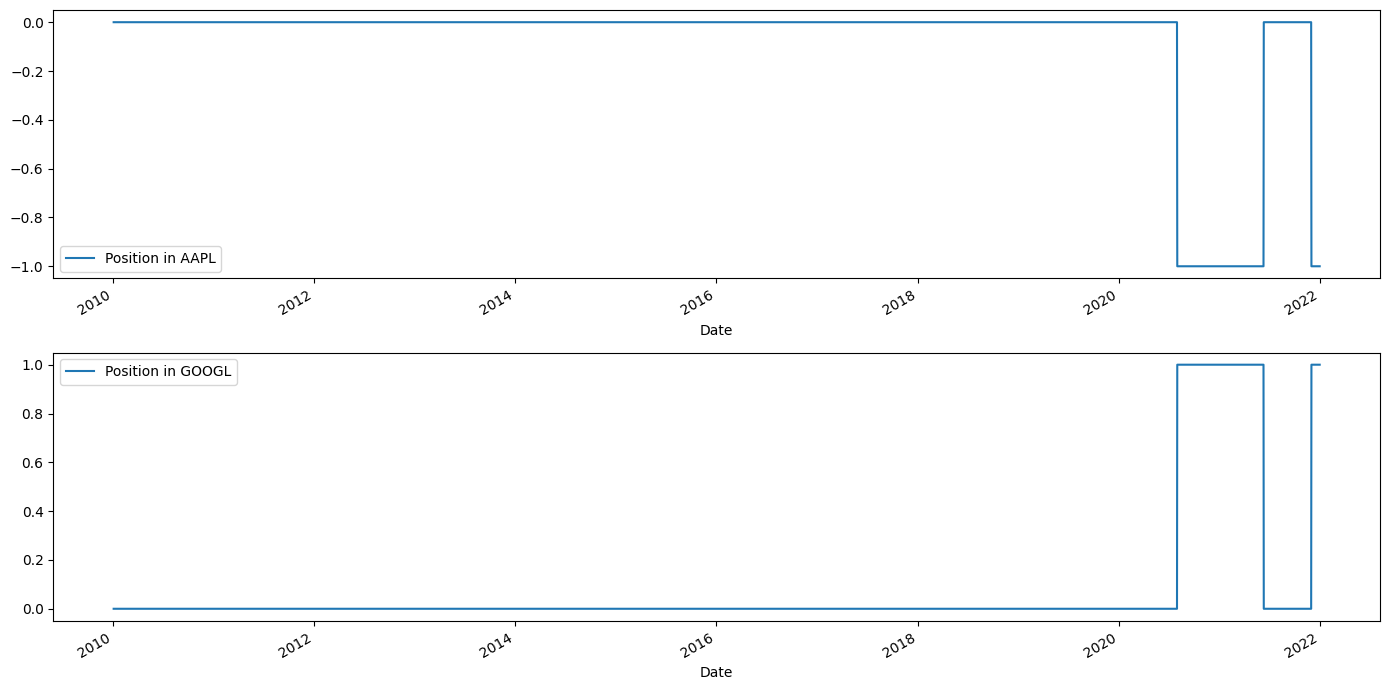

In [ ]:
# Plot positions
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
positions[stock1].plot(label=f'Position in {stock1}')
plt.legend()

plt.subplot(2, 1, 2)
positions[stock2].plot(label=f'Position in {stock2}')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
stock1, stock2 = pairs[1]

spread = data[stock1] - data[stock2]
zscore_spread = zscore(spread)

In [ ]:
# Define trading signals based on z-score for AAPL and MSFT
positions = pd.DataFrame(index=data.index)
positions[stock1] = 0
positions[stock2] = 0

for i in range(len(data)):
    if zscore_spread[i] > entry_zscore:
        positions[stock1].iloc[i] = -1  # Short stock1
        positions[stock2].iloc[i] = 1   # Long stock2
    elif zscore_spread[i] < -entry_zscore:
        positions[stock1].iloc[i] = 1   # Long stock1
        positions[stock2].iloc[i] = -1  # Short stock2
    elif abs(zscore_spread[i]) < exit_zscore:
        positions[stock1].iloc[i] = 0
        positions[stock2].iloc[i] = 0
    else:
        if i > 0:
            positions[stock1].iloc[i] = positions[stock1].iloc[i - 1]
            positions[stock2].iloc[i] = positions[stock2].iloc[i - 1]

In [ ]:
# Calculate returns from positions
strategy_returns = (positions.shift(1) * daily_returns).sum(axis=1)

# Calculate cumulative returns for AAPL and MSFT strategy
cumulative_returns = (1 + strategy_returns).cumprod()

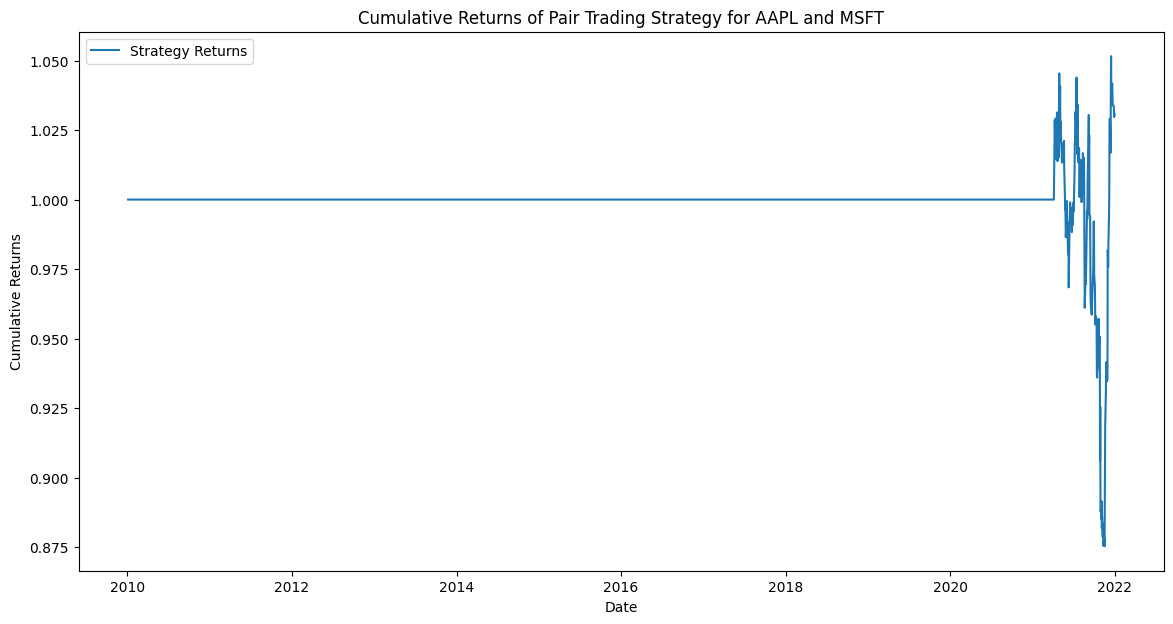

In [ ]:
# Plot cumulative returns for AAPL and MSFT strategy
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Pair Trading Strategy for AAPL and MSFT')
plt.legend()
plt.show()

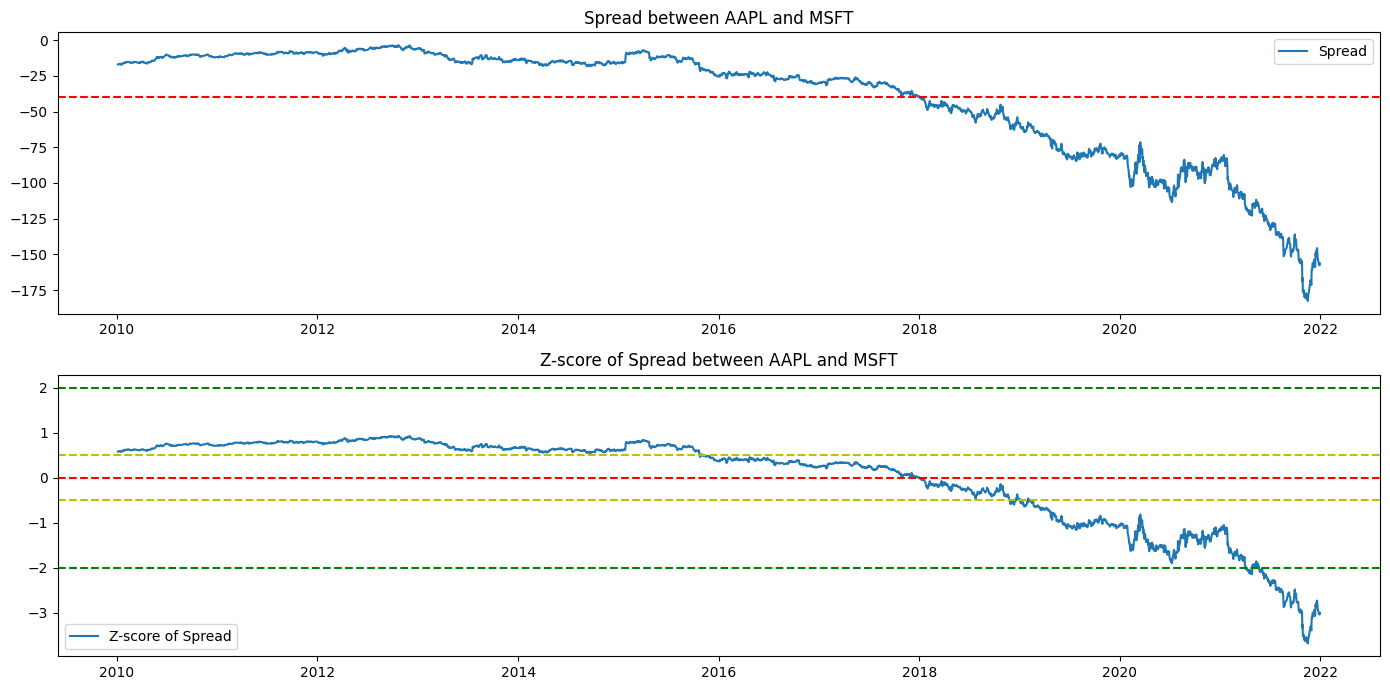

In [ ]:
# Plot the spread and z-score for AAPL and MSFT
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(spread, label='Spread')
plt.axhline(spread.mean(), color='r', linestyle='--')
plt.title(f'Spread between {stock1} and {stock2}')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(zscore_spread, label='Z-score of Spread')
plt.axhline(0, color='r', linestyle='--')
plt.axhline(entry_zscore, color='g', linestyle='--')
plt.axhline(-entry_zscore, color='g', linestyle='--')
plt.axhline(exit_zscore, color='y', linestyle='--')
plt.axhline(-exit_zscore, color='y', linestyle='--')
plt.title(f'Z-score of Spread between {stock1} and {stock2}')
plt.legend()

plt.tight_layout()
plt.show()

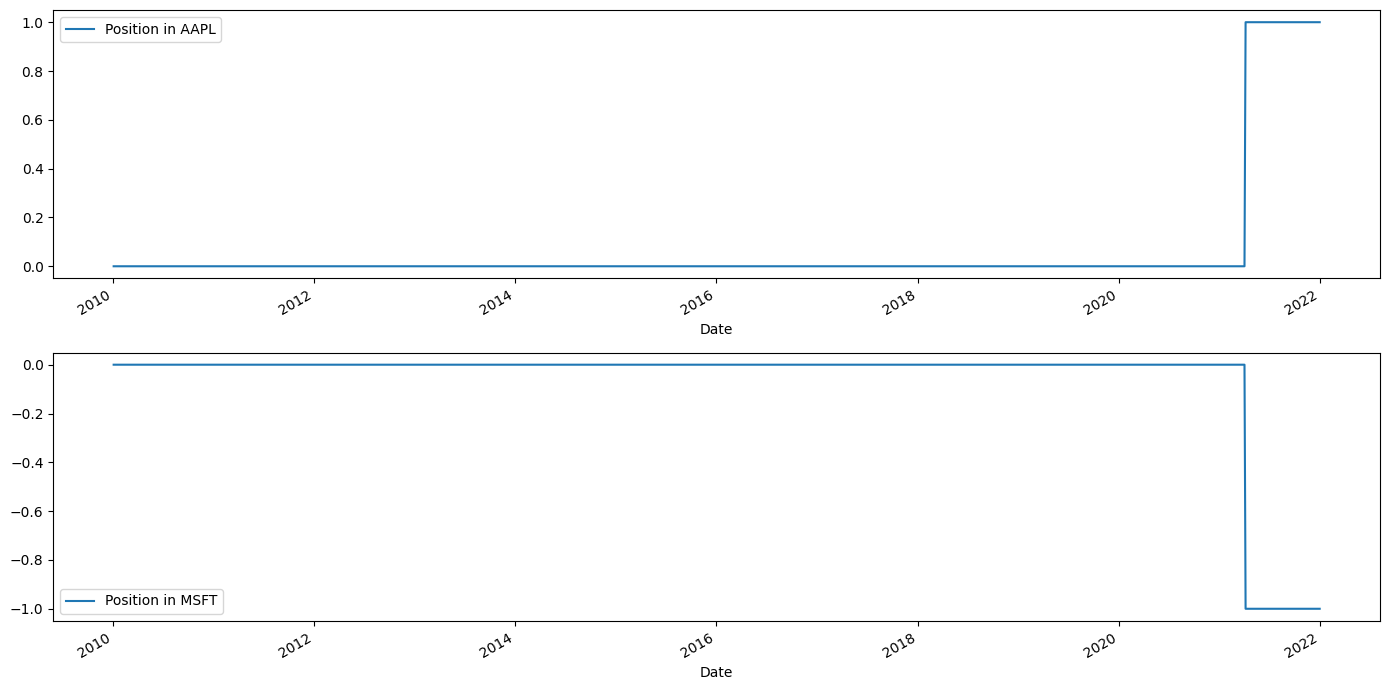

In [ ]:
# Plot positions
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
positions[stock1].plot(label=f'Position in {stock1}')
plt.legend()

plt.subplot(2, 1, 2)
positions[stock2].plot(label=f'Position in {stock2}')
plt.legend()

plt.tight_layout()
plt.show()